In [ ]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
sq_1hr = yf.download(tickers='SQ', start='2019-09-01', end = '2021-08-11', interval='1h')
sq_1hr.drop(columns = ['Open','High','Low','Adj Close','Volume'], inplace = True)
# sq_1hr.reset_index(inplace = True)
# sq_1hr.rename(columns = {'index' : 'DateTime'}, inplace = True)
# sq_1hr.set_index(pd.to_datetime(sq_1hr['DateTime'], infer_datetime_format = True), inplace = True)
# sq_1hr.drop(columns = 'DateTime', inplace = True)
sq_1hr

[*********************100%***********************]  1 of 1 completed


,Close
2019-09-03 09:30:00-04:00,62.959999
2019-09-03 10:30:00-04:00,62.320000
2019-09-03 11:30:00-04:00,62.000000
2019-09-03 12:30:00-04:00,61.774899
2019-09-03 13:30:00-04:00,61.360001
...,...
2021-08-10 11:30:00-04:00,277.697998
2021-08-10 12:30:00-04:00,276.769989
2021-08-10 13:30:00-04:00,275.375000
2021-08-10 14:30:00-04:00,274.049988


In [ ]:
sq_1hr.to_csv('SQ Hourly Close.csv')

In [ ]:

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

sq_macd = get_macd(sq_1hr['Close'], 26, 12, 9)
sq_macd.tail()

,macd,signal,hist
2021-08-10 11:30:00-04:00,3.626711,3.012416,0.614295
2021-08-10 12:30:00-04:00,3.810788,3.172090,0.638698
2021-08-10 13:30:00-04:00,3.800299,3.297732,0.502567
2021-08-10 14:30:00-04:00,3.643074,3.366800,0.276273
2021-08-10 15:30:00-04:00,3.389031,3.371247,0.017784


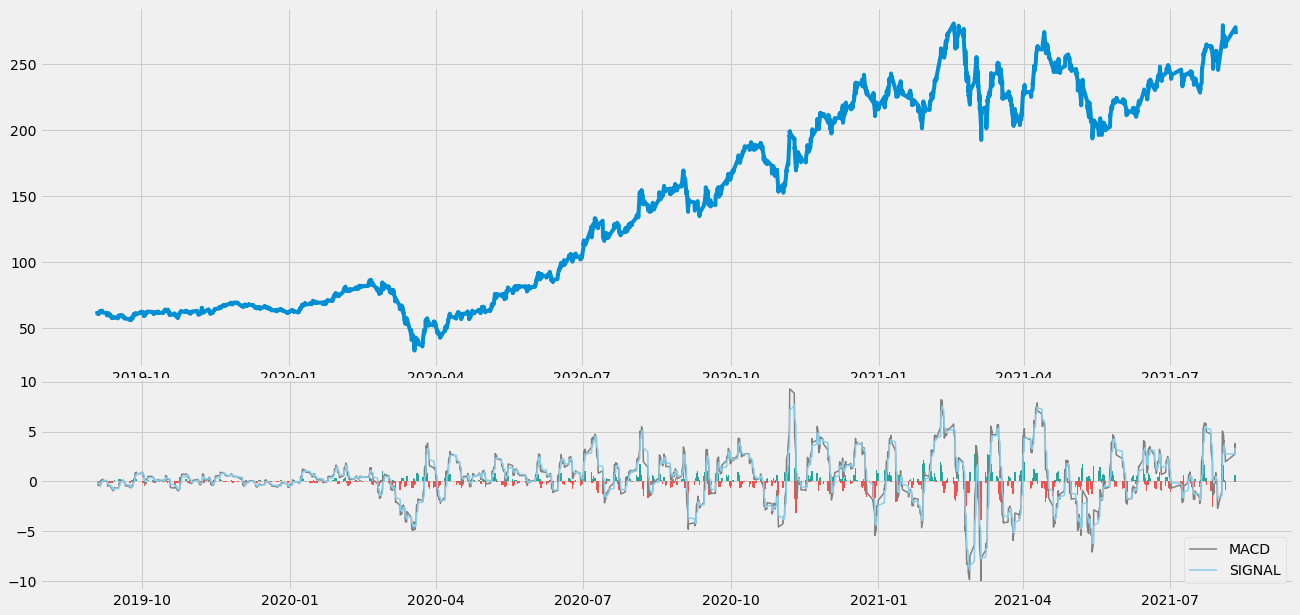

In [ ]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(sq_1hr['Close'], sq_macd['macd'], sq_macd['signal'], sq_macd['hist'])

In [ ]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(sq_1hr['Close'], sq_macd)

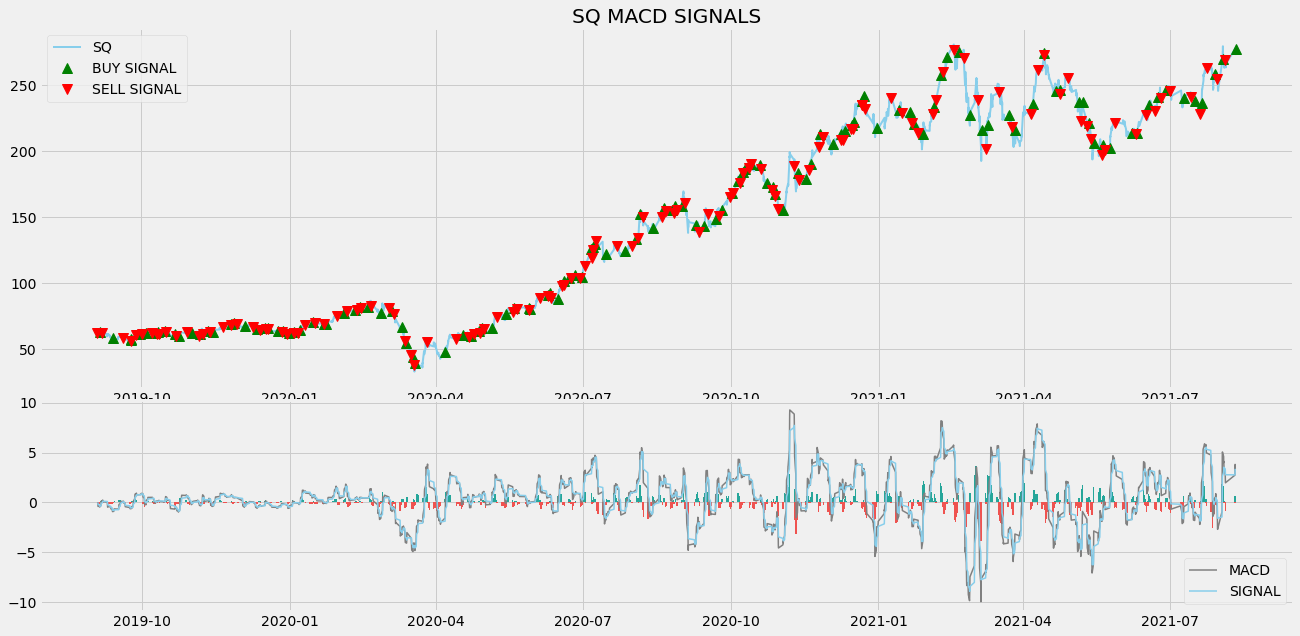

In [ ]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(sq_1hr['Close'], color = 'skyblue', linewidth = 2, label = 'SQ')
ax1.plot(sq_1hr.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(sq_1hr.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('SQ MACD SIGNALS')
ax2.plot(sq_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(sq_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(sq_macd)):
    if str(sq_macd['hist'][i])[0] == '-':
        ax2.bar(sq_macd.index[i], sq_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(sq_macd.index[i], sq_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(sq_1hr['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = sq_macd['macd']
signal = sq_macd['signal']
close_price = sq_1hr['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(sq_1hr.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(sq_1hr.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,macd,signal,macd_signal,macd_position
2019-09-03 09:30:00-04:00,62.959999,0.000000,0.000000,0,1
2019-09-03 10:30:00-04:00,62.320000,-0.051054,-0.010211,-1,0
2019-09-03 11:30:00-04:00,62.000000,-0.115999,-0.031368,0,0
2019-09-03 12:30:00-04:00,61.774899,-0.183517,-0.061798,0,0
2019-09-03 13:30:00-04:00,61.360001,-0.267421,-0.102923,0,0
...,...,...,...,...,...
2021-08-10 11:30:00-04:00,277.697998,3.626711,3.012416,0,1
2021-08-10 12:30:00-04:00,276.769989,3.810788,3.172090,0,1
2021-08-10 13:30:00-04:00,275.375000,3.800299,3.297732,0,1
2021-08-10 14:30:00-04:00,274.049988,3.643074,3.366800,0,1


In [ ]:

sq_ret = pd.DataFrame(np.diff(sq_1hr['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(sq_ret)):
    try:
        returns = sq_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/sq_1hr['Close'][-1])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in SQ : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing $100k in SQ : 44827.46
Profit percentage of the MACD strategy : 44%


In [ ]:
strategy.to_csv('SQ 1H MACD TRADE STRATEGY.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>